<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дипломный проект по теме "**Прогнозирование цен акций строительных компаний России на основе фундаментальных показателей**"

Связи с ограниченными вычислительными ресурсами, работа носит не сколько практический, сколько демонстрационный характер, однако позволяет оценить разные модели, а также эффективность моделей на разных входных параметрах.

In [ ]:
#Загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import datetime
import matplotlib.pyplot as plt

In [ ]:
# Загружаем цены акций строительных компаний РФ за доступный период
df = pd.read_csv('/content/prices.csv')

In [ ]:
df.head()
#df.tail(10)

,id,company_id,date,close,open,high,low,volume,adj_close
0,0,24,2007-06-29,657.0,657.0,657.00,657.0,66,657.0
1,0,24,2007-07-02,669.0,669.0,669.00,669.0,1,669.0
2,0,24,2007-07-03,662.0,662.0,662.00,662.0,3,662.0
3,0,24,2007-07-04,639.0,645.0,645.00,639.0,27,639.0
4,0,24,2007-07-05,657.0,666.0,745.17,652.0,10538,657.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14116 entries, 0 to 14115
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          14116 non-null  int64  
 1   company_id  14116 non-null  int64  
 2   date        14116 non-null  object 
 3   close       14116 non-null  float64
 4   open        14116 non-null  float64
 5   high        14116 non-null  float64
 6   low         14116 non-null  float64
 7   volume      14116 non-null  int64  
 8   adj_close   14116 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 992.7+ KB


In [ ]:
df.describe()

,id,company_id,close,open,high,low,volume,adj_close
count,14116.0,14116.000000,14116.000000,14116.000000,14116.000000,14116.000000,1.411600e+04,14116.000000
mean,0.0,411.508997,567.052620,568.057795,577.288619,557.093403,1.063930e+07,567.052620
std,0.0,1265.594910,775.061274,777.389203,789.922156,760.180852,1.517441e+08,775.061274
min,0.0,24.000000,19.410000,19.500000,20.170000,19.400000,0.000000e+00,19.410000
25%,0.0,24.000000,108.487500,108.500000,110.000000,107.197500,1.620150e+04,108.487500
50%,0.0,42.000000,308.650000,308.050000,312.500000,304.000000,6.928050e+04,308.650000
75%,0.0,87.000000,714.600000,715.000000,725.650000,705.000000,2.551600e+05,714.600000
max,0.0,4982.000000,5716.400000,5710.000000,5800.000000,5525.000000,7.907756e+09,5716.400000


Рассмотрим графики цен для каждой компании

In [ ]:
# Преобразуем дату
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.loc[df['close'].isnull()]


,id,company_id,date,close,open,high,low,volume,adj_close


In [ ]:
# Получаем список уникальных company_id
company_ids = df['company_id'].unique()

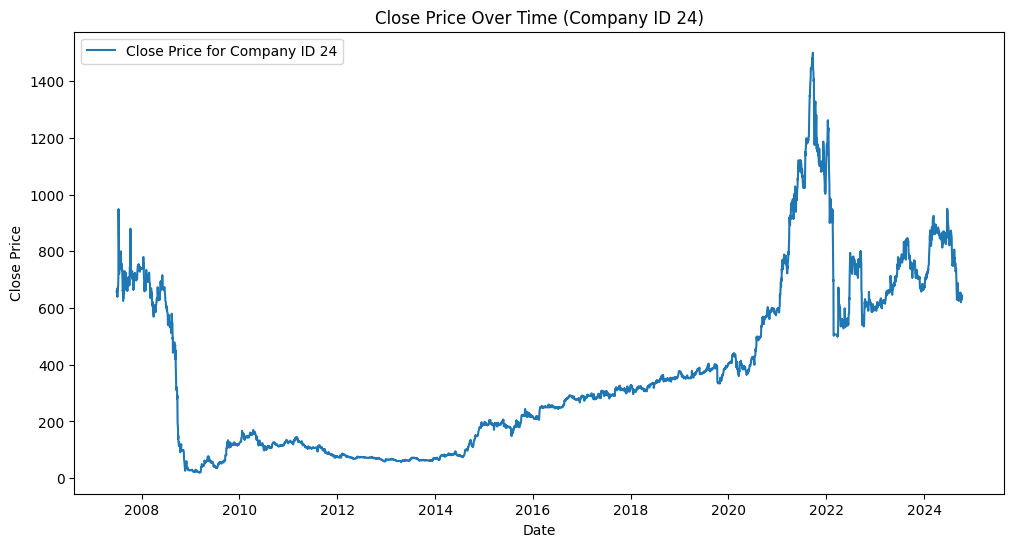

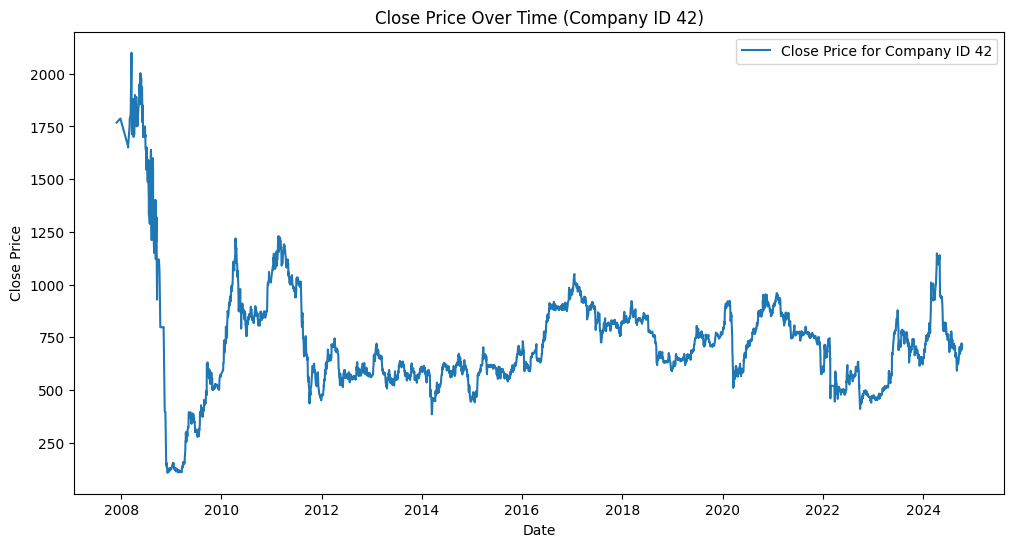

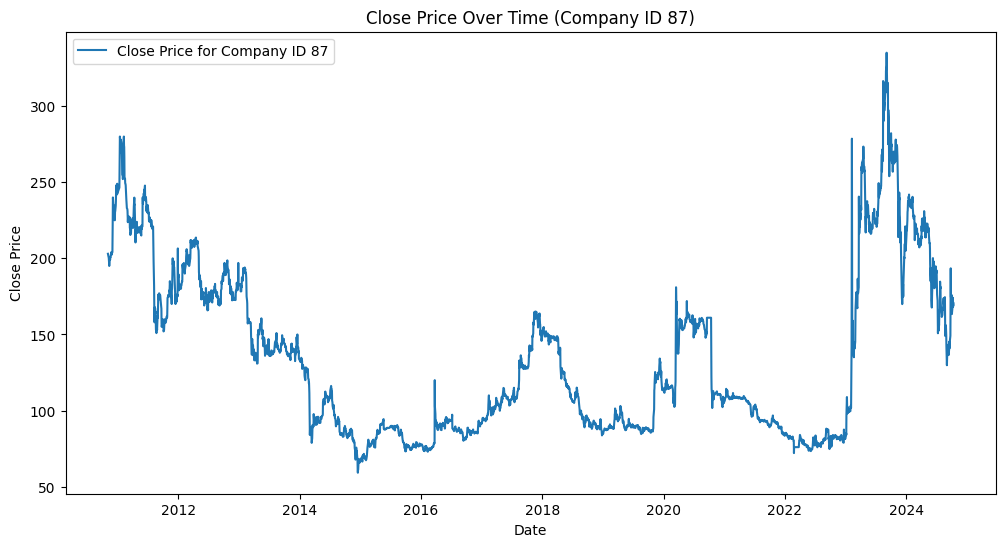

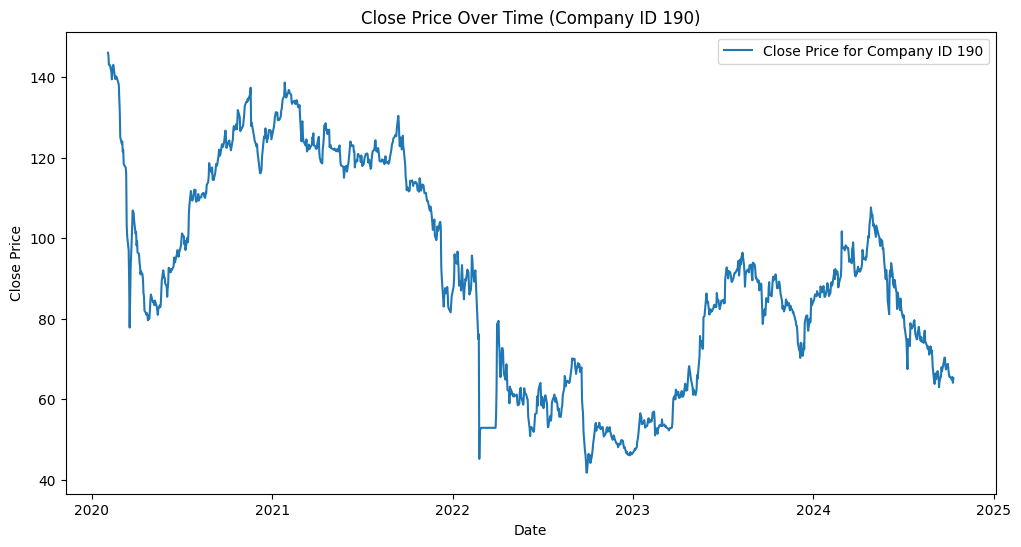

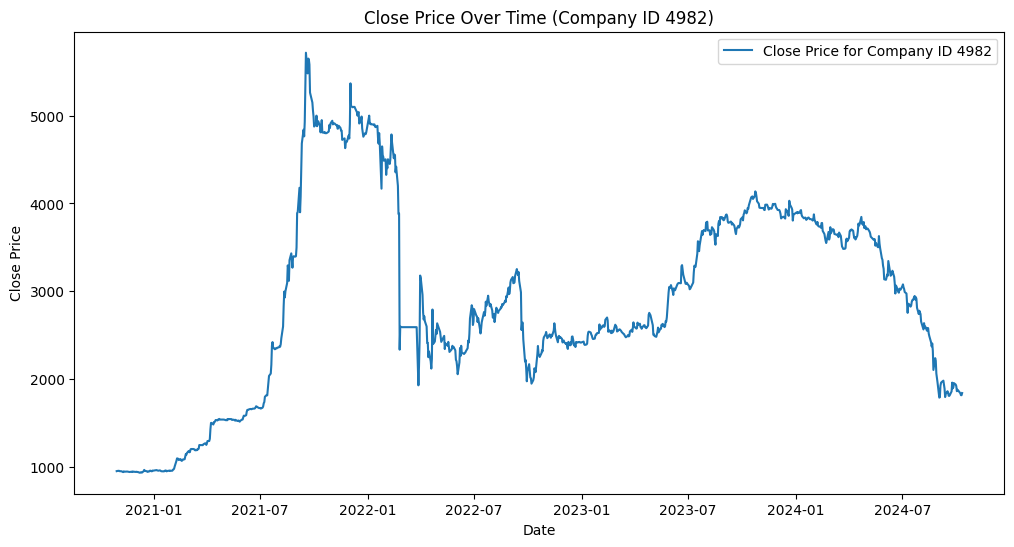

In [ ]:
# Построим график цены акции для каждой компании
for company_id in company_ids:
    # Фильтрация данных для текущей компании
    company_data = df[df['company_id'] == company_id].sort_values(by='date')

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(company_data['date'], company_data['close'], label=f"Close Price for Company ID {company_id}")
    plt.title(f"Close Price Over Time (Company ID {company_id})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()


In [ ]:
# Выведем основные статистики для каждой компании
for company_id in company_ids:
    # Фильтрация данных для текущей компании
    print(f"Company ID {company_id}")
    print(df[df['company_id'] == company_id]['close'].describe())
    print("\n")  # Пустая строка для разделения вывода


Company ID 24
count    4317.000000
mean      369.556495
std       301.220085
min        19.410000
25%       110.000000
50%       292.500000
75%       602.000000
max      1500.000000
Name: close, dtype: float64


Company ID 42
count    4098.000000
mean      715.678204
std       241.858899
min       108.020000
25%       575.025000
50%       681.600000
75%       834.000000
max      2099.400000
Name: close, dtype: float64


Company ID 87
count    3507.000000
mean      133.531417
std        54.119641
min        59.200000
25%        88.950000
50%       111.090000
75%       169.960000
max       335.050000
Name: close, dtype: float64


Company ID 190
count    1190.000000
mean       90.259697
std        26.236145
min        41.780000
25%        67.060000
50%        89.200000
75%       116.060000
max       146.000000
Name: close, dtype: float64


Company ID 4982
count    1004.000000
mean     2889.030279
std      1109.699379
min       935.000000
25%      2293.750000
50%      2708.250000
75%      

In [ ]:
# Удаление выбросов с помощью IQR
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)]
    return data

In [ ]:
# Очистка данных (удаление выбросов)
for company_id in df['company_id'].unique():
    df.loc[df['company_id'] == company_id, 'close'] = remove_outliers(df[df['company_id'] == company_id], 'close')['close']

In [ ]:
# Проверяем наличие пустых значений цены акций после удаления выбросов
df.loc[df['close'].isnull()]

,id,company_id,date,close,open,high,low,volume,adj_close
3524,0,24,2021-08-30,NaN,1335.0,1433.80,1315.5,1526210,1350.00
3525,0,24,2021-08-31,NaN,1368.5,1368.90,1331.2,308103,1345.90
3526,0,24,2021-09-01,NaN,1354.0,1372.00,1339.4,251136,1370.00
3527,0,24,2021-09-02,NaN,1375.0,1392.00,1360.6,326781,1383.00
3528,0,24,2021-09-03,NaN,1390.0,1400.00,1380.2,305391,1389.60
...,...,...,...,...,...,...,...,...,...
11642,0,87,2023-09-08,NaN,322.9,327.25,294.0,493260,313.60
11643,0,87,2023-09-11,NaN,313.6,325.00,303.8,309080,311.30
11644,0,87,2023-09-12,NaN,312.0,324.90,312.0,285850,315.25
11645,0,87,2023-09-13,NaN,316.0,325.00,308.8,316920,312.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14116 entries, 0 to 14115
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          14116 non-null  int64         
 1   company_id  14116 non-null  int64         
 2   date        14116 non-null  datetime64[ns]
 3   close       13887 non-null  float64       
 4   open        14116 non-null  float64       
 5   high        14116 non-null  float64       
 6   low         14116 non-null  float64       
 7   volume      14116 non-null  int64         
 8   adj_close   14116 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 992.7 KB


In [ ]:
# Заполнение NaN значений предыдущими значениями (forward fill)
df['close'] = df['close'].ffill()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14116 entries, 0 to 14115
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          14116 non-null  int64         
 1   company_id  14116 non-null  int64         
 2   date        14116 non-null  datetime64[ns]
 3   close       14116 non-null  float64       
 4   open        14116 non-null  float64       
 5   high        14116 non-null  float64       
 6   low         14116 non-null  float64       
 7   volume      14116 non-null  int64         
 8   adj_close   14116 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 992.7 KB


In [ ]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_close'] = scaler.fit_transform(df[['close']])

In [ ]:
df.head()

,id,company_id,date,close,open,high,low,volume,adj_close,scaled_close
0,0,24,2007-06-29,657.0,657.0,657.00,657.0,66,657.0,0.111917
1,0,24,2007-07-02,669.0,669.0,669.00,669.0,1,669.0,0.114023
2,0,24,2007-07-03,662.0,662.0,662.00,662.0,3,662.0,0.112795
3,0,24,2007-07-04,639.0,645.0,645.00,639.0,27,639.0,0.108757
4,0,24,2007-07-05,657.0,666.0,745.17,652.0,10538,657.0,0.111917


In [ ]:
# Создание последовательностей для LSTM, берем интервалы рывные 60 значений цены акции
sequence_length = 60
X, y = [], []
for company_id in df['company_id'].unique():
    company_data = df[df['company_id'] == company_id]['scaled_close'].values
    for i in range(sequence_length, len(company_data)):
        X.append(company_data[i-sequence_length:i])
        y.append(company_data[i])

In [ ]:
df['close'] = df['close'].ffill()

In [ ]:
X[0]

array([0.11191699, 0.11402337, 0.11279465, 0.10875743, 0.11191699,
       0.11198721, 0.11483784, 0.11563826, 0.11892771, 0.12192228,
       0.16310543, 0.14051806, 0.12307376, 0.12332828, 0.128768  ,
       0.13104991, 0.12814486, 0.13173097, 0.1282414 , 0.12604024,
       0.12736199, 0.1362035 , 0.13701797, 0.12999672, 0.12911906,
       0.12473078, 0.12578397, 0.12385312, 0.11244359, 0.1130755 ,
       0.11226806, 0.10629122, 0.10822206, 0.10805531, 0.11031439,
       0.11270689, 0.11068828, 0.11595421, 0.12473078, 0.12279993,
       0.11946484, 0.11776745, 0.11913484, 0.12104462, 0.12297547,
       0.12297547, 0.12367759, 0.12341429, 0.11294385, 0.12063037,
       0.11999143, 0.11244359, 0.11934723, 0.11770953, 0.11775517,
       0.11946484, 0.11946484, 0.11595246, 0.11841165, 0.11612799])

In [ ]:
y[0]

0.12104462180906059

In [ ]:
# Преобразуем списки в массивы numpy
X, y = np.array(X), np.array(y)

In [ ]:
X[0]

array([0.11191699, 0.11402337, 0.11279465, 0.10875743, 0.11191699,
       0.11198721, 0.11483784, 0.11563826, 0.11892771, 0.12192228,
       0.16310543, 0.14051806, 0.12307376, 0.12332828, 0.128768  ,
       0.13104991, 0.12814486, 0.13173097, 0.1282414 , 0.12604024,
       0.12736199, 0.1362035 , 0.13701797, 0.12999672, 0.12911906,
       0.12473078, 0.12578397, 0.12385312, 0.11244359, 0.1130755 ,
       0.11226806, 0.10629122, 0.10822206, 0.10805531, 0.11031439,
       0.11270689, 0.11068828, 0.11595421, 0.12473078, 0.12279993,
       0.11946484, 0.11776745, 0.11913484, 0.12104462, 0.12297547,
       0.12297547, 0.12367759, 0.12341429, 0.11294385, 0.12063037,
       0.11999143, 0.11244359, 0.11934723, 0.11770953, 0.11775517,
       0.11946484, 0.11946484, 0.11595246, 0.11841165, 0.11612799])

In [ ]:
y[0]

0.12104462180906059

In [ ]:
len(X)

13816

In [ ]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
X_train[0]

array([0.11191699, 0.11402337, 0.11279465, 0.10875743, 0.11191699,
       0.11198721, 0.11483784, 0.11563826, 0.11892771, 0.12192228,
       0.16310543, 0.14051806, 0.12307376, 0.12332828, 0.128768  ,
       0.13104991, 0.12814486, 0.13173097, 0.1282414 , 0.12604024,
       0.12736199, 0.1362035 , 0.13701797, 0.12999672, 0.12911906,
       0.12473078, 0.12578397, 0.12385312, 0.11244359, 0.1130755 ,
       0.11226806, 0.10629122, 0.10822206, 0.10805531, 0.11031439,
       0.11270689, 0.11068828, 0.11595421, 0.12473078, 0.12279993,
       0.11946484, 0.11776745, 0.11913484, 0.12104462, 0.12297547,
       0.12297547, 0.12367759, 0.12341429, 0.11294385, 0.12063037,
       0.11999143, 0.11244359, 0.11934723, 0.11770953, 0.11775517,
       0.11946484, 0.11946484, 0.11595246, 0.11841165, 0.11612799])

In [ ]:
X_test[0]

array([0.01287346, 0.01282081, 0.01295245, 0.01289979, 0.01288224,
       0.01270671, 0.01284714, 0.01272426, 0.01273304, 0.01261017,
       0.0127857 , 0.01275937, 0.01280325, 0.01271549, 0.01261017,
       0.01265405, 0.01225033, 0.01224155, 0.01217134, 0.01221522,
       0.01208357, 0.01220645, 0.012224  , 0.01231176, 0.01226788,
       0.01219767, 0.01224155, 0.01216256, 0.01206602, 0.012224  ,
       0.01229421, 0.01173251, 0.0115131 , 0.01158331, 0.01169741,
       0.0116623 , 0.01139023, 0.01152187, 0.01160964, 0.0115482 ,
       0.0115482 , 0.01138145, 0.0113639 , 0.01125858, 0.01124102,
       0.01148677, 0.01152187, 0.01146044, 0.01158331, 0.01158331,
       0.01146921, 0.01146921, 0.01141656, 0.01130246, 0.01135512,
       0.01114448, 0.01112693, 0.01110938, 0.01123225, 0.01109182])

In [ ]:
y_train[0]

0.12104462180906059

In [ ]:
y_test[0]

0.010863631496632432

In [ ]:
# Проверяем строки на отсутсвие цены акции
df.loc[df['scaled_close'].isnull()]

,id,company_id,date,close,open,high,low,volume,adj_close,scaled_close


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Input

# Создаем модель
model = Sequential()

# Добавляем Input слой с указанием input_shape
model.add(Input(shape=(X_train.shape[1], 1)))  # Это указывает форму входных данных

# Добавляем LSTM слои и другие необходимые слои
model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=50))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=1))


In [ ]:

# Проверка на NaN или бесконечные значения в тренировочном и тестовом наборах
print("NaN in X_train:", np.isnan(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("NaN in X_test:", np.isnan(X_test).any())
print("NaN in y_test:", np.isnan(y_test).any())

print("Inf in X_train:", np.isinf(X_train).any())
print("Inf in y_train:", np.isinf(y_train).any())
print("Inf in X_test:", np.isinf(X_test).any())
print("Inf in y_test:", np.isinf(y_test).any())


NaN in X_train: False
NaN in y_train: False
NaN in X_test: False
NaN in y_test: False
Inf in X_train: False
Inf in y_train: False
Inf in X_test: False
Inf in y_test: False


In [ ]:
# Проверяем максимальные и минимальные значения после нормализации
print("X_train range:", X_train.min(), X_train.max())
print("y_train range:", y_train.min(), y_train.max())


X_train range: 0.0 0.2297687024200499
y_train range: 0.0 0.2297687024200499


In [ ]:
from keras.callbacks import EarlyStopping
# Связи с ограниченными вычислительными ресурсами,
# прекращаем обучение, когда отслеживаемый показатель перестанет улучшаться.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Проверка модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,451 (595.51 KB)

 Trainable params: 151,951 (593.56 KB)

 Non-trainable params: 500 (1.95 KB)

In [ ]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 1.2151 - val_loss: 0.0758
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0095 - val_loss: 0.0615
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 5.3355e-04 - val_loss: 0.0591
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.4393e-04 - val_loss: 0.0570
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 4.2489e-04 - val_loss: 0.0566
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.7220e-04 - val_loss: 0.0528
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.6690e-04 - val_loss: 0.0564
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5577e-04 - val_loss: 0.0507
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.2502e-04 - val_loss: 0.0458
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 3.5232e-04 - val_loss: 0.0519
Epoch 11/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 3.5811e-04 - val_loss: 0.0498

In [ ]:
# Сохраняем обученую модель
model.save('DL_project_lstm.keras')


In [ ]:
# Оценка на тестовой выборке
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Test Loss: 0.012052238918840885


In [ ]:
# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Пример использования
y_pred = model.predict(X_test)  # Предсказания модели
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}%")
# Данный показатель больше 100%, что не корректно и MAPE в задачах временныъ рядов часто заменяют на MAE

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAPE: 746.2246237180018%


In [ ]:
# MAE (Mean Absolute Error)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


MAE: 0.059599760618657266


In [ ]:
# RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 0.10978268842854765


In [ ]:
# Для сравнения различных моделей и нахождения лучшего варианта создадим модель GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Создаем модель
gru_model = Sequential()

# Добавляем Input слой с указанием input_shape
gru_model.add(Input(shape=(X_train.shape[1], 1)))  # Указываем форму входных данных

# Добавляем GRU слои и другие необходимые слои
gru_model.add(GRU(units=100, return_sequences=True))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(GRU(units=100, return_sequences=True))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(GRU(units=50))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(Dense(units=1))

# Компиляция модели
# Связи с ограниченными вычислительными ресурсами,
# прекращаем обучение, когда отслеживаемый показатель перестанет улучшаться.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
gru_model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Проверка модели
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 100)             │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 100)             │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,351 (450.59 KB)

 Trainable params: 114,851 (448.64 KB)

 Non-trainable params: 500 (1.95 KB)

In [ ]:
# Обучение модели
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 1.4759 - val_loss: 0.0649
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0214 - val_loss: 0.0622
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 5.4409e-04 - val_loss: 0.0620
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 5.6216e-04 - val_loss: 0.0620
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.9973e-04 - val_loss: 0.0604
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.8102e-04 - val_loss: 0.0622
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 5.0181e-04 - val_loss: 0.0603
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 4.7080e-04 - val_loss: 0.0566
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 4.4571e-04 - val_loss: 0.0596
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 3.8617e-04 - val_loss: 0.0555
Epoch 11/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 4.0230e-04 - val_loss: 0.0552
Epoc

In [ ]:
# Модель перестала улучшаться через 43 эпохи
# Сохраняем обученную модель
model.save('DL_project_gru.keras')

In [ ]:
# Оценка на тестовой выборке
test_loss = gru_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053
Test Loss: 0.013715102337300777


In [ ]:
# Пример использования
y_pred = gru_model.predict(X_test)  # Предсказания модели
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}%")
# Данный показатель больше 100%, что не корректно и MAPE в задачах временныъ рядов часто заменяют на MAE

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAPE: 928.0391327501188%


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.0669742829741531


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.11711149416205999


Во второй части задачи, к ценам акций добавляем исторические мультипликаторы компаний, такие как капитализация компании, финансовый коэффициент, отношение стоимости акции к годовой прибыли на акцию, цена к выручке, отношение рыночной оценки компании к балансовой стоимости компании и др., всего более 100 показателей для каждой компании, за известные периоды.

In [ ]:
# Load the new CSV files
prices_df = pd.read_csv('/content/prices.csv') #загружаем цены акций
ltm_multipliers_df = pd.read_csv('/content/ltm_multipliers.csv') #загружаем мультипликаторы компаний

In [ ]:
prices_df.head()

,id,company_id,date,close,open,high,low,volume,adj_close
0,0,24,2007-06-29,657.0,657.0,657.00,657.0,66,657.0
1,0,24,2007-07-02,669.0,669.0,669.00,669.0,1,669.0
2,0,24,2007-07-03,662.0,662.0,662.00,662.0,3,662.0
3,0,24,2007-07-04,639.0,645.0,645.00,639.0,27,639.0
4,0,24,2007-07-05,657.0,666.0,745.17,652.0,10538,657.0


In [ ]:
# Преобразуем дату
prices_df['date'] = pd.to_datetime(prices_df['date'])

In [ ]:
ltm_multipliers_df.head()

,id,company_id,start_date,end_date,share_price,shares,mkt_cap,p_e,p_s,p_bv,...,netDebt_FCF,pretax_roa,pretax_roe,debt_ebitda,debt_FCF,reinvestment_rate,long_term_debt_to_asset,ocfr,capex_cfo,capex_amortization
0,820,24,2014-09-30,2015-03-31,193.0,660626029.0,127500823597,18.39,2.26,5.15,...,0.68,4.85,20.82,2.67,2.60,-3.65,0.17,0.15,0.02,0.36
1,819,24,2014-12-31,2015-06-30,180.1,660626029.0,118978747823,15.12,2.33,4.80,...,0.85,6.08,26.09,2.24,3.28,-4.14,0.17,0.12,0.03,0.42
2,818,24,2015-01-31,2015-09-30,191.1,660367971.0,126196319258,12.15,2.56,3.95,...,-2.71,8.65,28.90,0.02,0.04,-2.68,0.00,0.11,0.05,0.54
3,817,24,2015-03-31,2015-12-31,215.5,660367971.0,142309297750,12.74,2.78,4.46,...,-1.92,12.45,41.59,0.02,0.03,-2.55,0.00,0.16,0.05,0.56
4,816,24,2015-06-30,2016-01-31,215.0,660497000.0,142006855000,10.01,2.58,0.00,...,0.00,NaN,NaN,0.00,0.00,NaN,NaN,NaN,0.05,0.57


In [ ]:
# Преобразуем дату
ltm_multipliers_df['end_date'] = pd.to_datetime(ltm_multipliers_df['end_date'])

In [ ]:
# Очистка данных (удаление выбросов)
for company_id in prices_df['company_id'].unique():
    prices_df.loc[prices_df['company_id'] == company_id, 'close'] = remove_outliers(prices_df[prices_df['company_id'] == company_id], 'close')['close']

In [ ]:
prices_df.head()

,id,company_id,date,close,open,high,low,volume,adj_close
0,0,24,2007-06-29,657.0,657.0,657.00,657.0,66,657.0
1,0,24,2007-07-02,669.0,669.0,669.00,669.0,1,669.0
2,0,24,2007-07-03,662.0,662.0,662.00,662.0,3,662.0
3,0,24,2007-07-04,639.0,645.0,645.00,639.0,27,639.0
4,0,24,2007-07-05,657.0,666.0,745.17,652.0,10538,657.0


In [ ]:
prices_df.loc[prices_df['close'].isnull()]

,id,company_id,date,close,open,high,low,volume,adj_close
3524,0,24,2021-08-30,NaN,1335.0,1433.80,1315.5,1526210,1350.00
3525,0,24,2021-08-31,NaN,1368.5,1368.90,1331.2,308103,1345.90
3526,0,24,2021-09-01,NaN,1354.0,1372.00,1339.4,251136,1370.00
3527,0,24,2021-09-02,NaN,1375.0,1392.00,1360.6,326781,1383.00
3528,0,24,2021-09-03,NaN,1390.0,1400.00,1380.2,305391,1389.60
...,...,...,...,...,...,...,...,...,...
11642,0,87,2023-09-08,NaN,322.9,327.25,294.0,493260,313.60
11643,0,87,2023-09-11,NaN,313.6,325.00,303.8,309080,311.30
11644,0,87,2023-09-12,NaN,312.0,324.90,312.0,285850,315.25
11645,0,87,2023-09-13,NaN,316.0,325.00,308.8,316920,312.60


In [ ]:
# Заполнение NaN значений предыдущими значениями (forward fill)
prices_df['close'] = prices_df['close'].ffill()

In [ ]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14116 entries, 0 to 14115
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          14116 non-null  int64         
 1   company_id  14116 non-null  int64         
 2   date        14116 non-null  datetime64[ns]
 3   close       14116 non-null  float64       
 4   open        14116 non-null  float64       
 5   high        14116 non-null  float64       
 6   low         14116 non-null  float64       
 7   volume      14116 non-null  int64         
 8   adj_close   14116 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 992.7 KB


In [ ]:
prices_df['company_id'].unique()

array([  24,   42,   87,  190, 4982])

In [ ]:
#оставляем данные мультипликаторов только строительных компаний используемых в наших временныъ рядах
ltm_multipliers_df = ltm_multipliers_df.loc[ltm_multipliers_df['company_id'].isin(prices_df['company_id'].unique())]

In [ ]:
ltm_multipliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166 entries, 0 to 165
Columns: 107 entries, id to capex_amortization
dtypes: datetime64[ns](1), float64(100), int64(5), object(1)
memory usage: 140.1+ KB


In [ ]:
ltm_multipliers_df.head()

,id,company_id,start_date,end_date,share_price,shares,mkt_cap,p_e,p_s,p_bv,...,netDebt_FCF,pretax_roa,pretax_roe,debt_ebitda,debt_FCF,reinvestment_rate,long_term_debt_to_asset,ocfr,capex_cfo,capex_amortization
0,820,24,2014-09-30,2015-03-31,193.0,660626029.0,127500823597,18.39,2.26,5.15,...,0.68,4.85,20.82,2.67,2.60,-3.65,0.17,0.15,0.02,0.36
1,819,24,2014-12-31,2015-06-30,180.1,660626029.0,118978747823,15.12,2.33,4.80,...,0.85,6.08,26.09,2.24,3.28,-4.14,0.17,0.12,0.03,0.42
2,818,24,2015-01-31,2015-09-30,191.1,660367971.0,126196319258,12.15,2.56,3.95,...,-2.71,8.65,28.90,0.02,0.04,-2.68,0.00,0.11,0.05,0.54
3,817,24,2015-03-31,2015-12-31,215.5,660367971.0,142309297750,12.74,2.78,4.46,...,-1.92,12.45,41.59,0.02,0.03,-2.55,0.00,0.16,0.05,0.56
4,816,24,2015-06-30,2016-01-31,215.0,660497000.0,142006855000,10.01,2.58,0.00,...,0.00,NaN,NaN,0.00,0.00,NaN,NaN,NaN,0.05,0.57


In [ ]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14116 entries, 0 to 14115
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          14116 non-null  int64         
 1   company_id  14116 non-null  int64         
 2   date        14116 non-null  datetime64[ns]
 3   close       14116 non-null  float64       
 4   open        14116 non-null  float64       
 5   high        14116 non-null  float64       
 6   low         14116 non-null  float64       
 7   volume      14116 non-null  int64         
 8   adj_close   14116 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 992.7 KB


In [ ]:
# Убедимся, что данные отсортированы по 'company_id' и дате
prices_df = prices_df.sort_values(by=['company_id', 'date']).reset_index(drop=True)
ltm_multipliers_df = ltm_multipliers_df.sort_values(by=['company_id', 'end_date']).reset_index(drop=True)

In [ ]:
# В данном блоке соединяем по дате цены акций и мультипликаторы для каждой компании,
# связи с тем, что мультипликаторы известны только в квартальных отчетах, а цена акции меняется каждый день,
# делаем сапоставление данных цены до ближайшего отчета, чтобы в таблице не было пустых значений
merged_list = []
for i in prices_df['company_id'].unique():
  merged_group = pd.merge_asof(
        prices_df.loc[prices_df['company_id'] == i],
        ltm_multipliers_df.loc[ltm_multipliers_df['company_id'] == i],
        left_on='date',              # Дата в таблице цен
        right_on='end_date',         # Дата отчета в таблице мультипликаторов
        by='company_id',             # Поиск по каждому `company_id`
        direction='nearest'         # Берем ближайшие предыдущие значения
    )
  merged_list.append(merged_group)

In [ ]:
# Объединим обратно все группы
merged_df = pd.concat(merged_list, ignore_index=True)

In [ ]:
# Объединенные данные будут выглядеть следующем образом
merged_df.head()

,id_x,company_id,date,close,open,high,low,volume,adj_close,id_y,...,netDebt_FCF,pretax_roa,pretax_roe,debt_ebitda,debt_FCF,reinvestment_rate,long_term_debt_to_asset,ocfr,capex_cfo,capex_amortization
0,0,24,2007-06-29,657.0,657.0,657.00,657.0,66,657.0,820,...,0.68,4.85,20.82,2.67,2.6,-3.65,0.17,0.15,0.02,0.36
1,0,24,2007-07-02,669.0,669.0,669.00,669.0,1,669.0,820,...,0.68,4.85,20.82,2.67,2.6,-3.65,0.17,0.15,0.02,0.36
2,0,24,2007-07-03,662.0,662.0,662.00,662.0,3,662.0,820,...,0.68,4.85,20.82,2.67,2.6,-3.65,0.17,0.15,0.02,0.36
3,0,24,2007-07-04,639.0,645.0,645.00,639.0,27,639.0,820,...,0.68,4.85,20.82,2.67,2.6,-3.65,0.17,0.15,0.02,0.36
4,0,24,2007-07-05,657.0,666.0,745.17,652.0,10538,657.0,820,...,0.68,4.85,20.82,2.67,2.6,-3.65,0.17,0.15,0.02,0.36


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14116 entries, 0 to 14115
Columns: 115 entries, id_x to capex_amortization
dtypes: datetime64[ns](2), float64(105), int64(7), object(1)
memory usage: 12.4+ MB


In [ ]:
print(list(merged_df.columns))

['id_x', 'company_id', 'date', 'close', 'open', 'high', 'low', 'volume', 'adj_close', 'id_y', 'start_date', 'end_date', 'share_price', 'shares', 'mkt_cap', 'p_e', 'p_s', 'p_bv', 'ev_ebitda', 'roe', 'ev', 'ev_ebit', 'p_fcf', 'ev_fcf', 'ev_cfo', 'ev_nopat', 'ev_s', 'net_debt_ebitda', 'eps', 'book_value_per_share', 'dupont', 'altman_model', 'graham', 'e_p', 'free_cash_flow_yield', 'roa', 'roaa', 'roae', 'oroa', 'rona', 'rooa', 'roic', 'roce', 'gross_margin', 'ebitda_margin', 'ebit_margin', 'operating_margin', 'pretax_margin', 'net_margin', 'net_debt_ebit', 'net_debt_net_income', 'net_debt_mcap', 'net_debt_asset', 'debt_asset', 'net_debt_equity', 'debt_equity', 'long_term_debt_to_equity', 'long_term_debt_to_nopat', 'free_cash_flow_debt', 'net_debt_oibda', 'debt_ratio', 'debt_to_equity_ratio', 'current_ratio', 'cash_ratio', 'quick_ratio', 'solvency_ratio', 'asset_coverage_ratio', 'capitalization_ratio', 'inventory_turnover', 'receivable_turnover_ratio', 'accounts_payable_turnover', 'cap_tur

In [ ]:
# Удаляем ненужные столбцы и столбцы. которые могут повлиять на обучение наших моделей
numeric_data = merged_df.drop(columns=['company_id', 'date', 'start_date', 'end_date', 'id_x', 'id_y', 'adj_close', 'open',	'high',	'low'], errors='ignore')

In [ ]:
# Нормализуем данные
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numeric_data = scaler.fit_transform(numeric_data)
scaled_data = merged_df[['company_id', 'date']].copy()
scaled_data = pd.concat([scaled_data, pd.DataFrame(scaled_numeric_data, columns=numeric_data.columns)], axis=1)

In [ ]:
scaled_data.head()

,company_id,date,close,volume,share_price,shares,mkt_cap,p_e,p_s,p_bv,...,netDebt_FCF,pretax_roa,pretax_roe,debt_ebitda,debt_FCF,reinvestment_rate,long_term_debt_to_asset,ocfr,capex_cfo,capex_amortization
0,24,2007-06-29,0.111917,8.346236e-09,0.030499,1.0,0.137872,0.064582,0.520737,0.028864,...,0.518608,0.020174,0.068134,0.309028,0.548897,0.906716,0.008517,0.879736,0.053719,0.009337
1,24,2007-07-02,0.114023,1.264581e-10,0.030499,1.0,0.137872,0.064582,0.520737,0.028864,...,0.518608,0.020174,0.068134,0.309028,0.548897,0.906716,0.008517,0.879736,0.053719,0.009337
2,24,2007-07-03,0.112795,3.793744e-10,0.030499,1.0,0.137872,0.064582,0.520737,0.028864,...,0.518608,0.020174,0.068134,0.309028,0.548897,0.906716,0.008517,0.879736,0.053719,0.009337
3,24,2007-07-04,0.108757,3.414369e-09,0.030499,1.0,0.137872,0.064582,0.520737,0.028864,...,0.518608,0.020174,0.068134,0.309028,0.548897,0.906716,0.008517,0.879736,0.053719,0.009337
4,24,2007-07-05,0.111917,1.332616e-06,0.030499,1.0,0.137872,0.064582,0.520737,0.028864,...,0.518608,0.020174,0.068134,0.309028,0.548897,0.906716,0.008517,0.879736,0.053719,0.009337


In [ ]:
# Разделяем данные на отрезки по 60 дней для каждой компании
sequence_length = 60
X, y = [], []

# Для каждого `company_id` создаем последовательности
for company_id in scaled_data['company_id'].unique():
    # Фильтруем данные для текущего `company_id`, удаляем столбцы `company_id`, `date` и целевую переменную `close`
    company_data = scaled_data[scaled_data['company_id'] == company_id].drop(columns=['company_id', 'date', 'close']).values

    # Заменяем NaN значения на ближайшие известные (forward fill)
    company_data = pd.DataFrame(company_data).ffill().reset_index(drop=True)

    # Создаем последовательности
    for i in range(sequence_length, len(company_data)):
        # X: последовательность за последние `sequence_length` шагов, включая все параметры (кроме `close`)
        X.append(company_data.iloc[i-sequence_length:i].values)

        # y: значение `scaled_close` для следующего шага (это целевая переменная)
        y.append(scaled_data[scaled_data['company_id'] == company_id].iloc[i]['close'])

# Преобразуем X и y в массивы numpy для модели
X, y = np.array(X), np.array(y)

In [ ]:
X[0]

array([[8.34623597e-09, 3.04988484e-02, 1.00000000e+00, ...,
        8.79735836e-01, 5.37190083e-02, 9.33706816e-03],
       [1.26458121e-10, 3.04988484e-02, 1.00000000e+00, ...,
        8.79735836e-01, 5.37190083e-02, 9.33706816e-03],
       [3.79374362e-10, 3.04988484e-02, 1.00000000e+00, ...,
        8.79735836e-01, 5.37190083e-02, 9.33706816e-03],
       ...,
       [7.46102912e-09, 3.04988484e-02, 1.00000000e+00, ...,
        8.79735836e-01, 5.37190083e-02, 9.33706816e-03],
       [2.52916241e-10, 3.04988484e-02, 1.00000000e+00, ...,
        8.79735836e-01, 5.37190083e-02, 9.33706816e-03],
       [1.26458121e-10, 3.04988484e-02, 1.00000000e+00, ...,
        8.79735836e-01, 5.37190083e-02, 9.33706816e-03]])

In [ ]:
y[0]

0.12104462180906059

In [ ]:
# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Убедимся, что данные имеют нужную форму
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])  # (samples, time_steps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])  # (samples, time_steps, features)

# Проверяем формы
print(X_train.shape)
print(X_test.shape)


(11052, 60, 104)
(2764, 60, 104)


In [ ]:
# Проверим данные на NaN и бесконечности
print(np.any(np.isnan(X_train)))  # Есть ли NaN в данных
print(np.any(np.isinf(X_train)))  # Есть ли бесконечности в данных

# Если они есть, можно их заменить
X_train = np.nan_to_num(X_train)  # Заменяет NaN и инф на 0
X_test = np.nan_to_num(X_test)


True
False


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Input
from keras.optimizers import Adam

# Создаем модель
model = Sequential()
# Модифицируем модель для нашего количества признаков
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)

# Добавляем Input слой с указанием input_shape
model.add(Input(shape=input_shape))  # Входной слой, который будет принимать несколько признаков

# Добавляем LSTM слои и другие необходимые слои
model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=50))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=1))  # Выходной слой

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Проверка модели
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          82,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,651 (756.45 KB)

 Trainable params: 193,151 (754.50 KB)

 Non-trainable params: 500 (1.95 KB)

In [ ]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1.3413 - val_loss: 0.0747
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0204 - val_loss: 0.0735
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0013 - val_loss: 0.0712
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0013 - val_loss: 0.0683
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0011 - val_loss: 0.0686
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0011 - val_loss: 0.0685
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0011 - val_loss: 0.0689
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0010 - val_loss: 0.0676
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 9.4889e-04 - val_loss: 0.0659
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 9.4528e-04 - val_loss: 0.0638


Замечаем, что показатель val_loss перестал меняться уже через 10 эпох обучения модели и обучение завершилось досрочно.

In [ ]:
# Сохраняем обученную модель
model.save('DL_project_lstm2.keras')

In [ ]:
# Оценка на тестовой выборке
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0201
Test Loss: 0.07467605918645859


In [ ]:
# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Пример использования
y_pred = model.predict(X_test)  # Предсказания модели
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}%")
# Данный показатель больше 100%, что не корректно и MAPE в задачах временныъ рядов часто заменяют на MAE

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MAPE: 449.352471370668%


In [ ]:
# MAE (Mean Absolute Error)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.19036275742546416


In [ ]:
# RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.27326919957486256


In [ ]:
from keras.models import Sequential
from keras.layers import GRU, BatchNormalization, Dropout, Dense, Input
from keras.optimizers import Adam

# Создаем модель
gru_model = Sequential()

# Модифицируем модель для нашего количества признаков
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)

# Добавляем Input слой с указанием input_shape
gru_model.add(Input(shape=input_shape))  # Входной слой, который будет принимать несколько признаков

# Добавляем GRU слои и другие необходимые слои
gru_model.add(GRU(units=100, return_sequences=True))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(GRU(units=100, return_sequences=True))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(GRU(units=50))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(Dense(units=1))  # Выходной слой

# Компиляция модели
gru_model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Проверка модели
gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 60, 100)             │          61,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 60, 100)             │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 60, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146,251 (571.29 KB)

 Trainable params: 145,751 (569.34 KB)

 Non-trainable params: 500 (1.95 KB)

In [ ]:
# Обучение модели
history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.9445 - val_loss: 0.0936
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0453 - val_loss: 0.0767
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0015 - val_loss: 0.0752
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0014 - val_loss: 0.0724
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0013 - val_loss: 0.0731
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0013 - val_loss: 0.0715
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0013 - val_loss: 0.0691
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0012 - val_loss: 0.0700
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0011 - val_loss: 0.0690
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0011 - val_loss: 0.0688


Замечаем, что показатель val_loss перестал меняться уже через 10 эпох обучения модели и обучение завершилось досрочно.

In [ ]:
# Сохраняем обученную модель
model.save('DL_project_gru2.keras')

In [ ]:
# Оценка на тестовой выборке
test_loss = gru_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0299
Test Loss: 0.09357526153326035


In [ ]:
y_pred = gru_model.predict(X_test)  # Предсказания модели
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}%")
# Данный показатель больше 100%, что не корректно и MAPE в задачах временныъ рядов часто заменяют на MAE

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAPE: 484.16202440437877%


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.21871568918564638


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.305900711564078


In [ ]:
p_loss_lstm = round(0.012052238918840885, 3)
p_mae_lstm = round(0.059599760618657266, 3)
p_rmse_lstm = round(0.10978268842854765, 3)
p_loss_gru = round(0.013715102337300777, 3)
p_mae_gru = round(0.0669742829741531, 3)
p_rmse_gru = round(0.11711149416205999, 3)
m_loss_lstm = round(0.07467605918645859, 3)
m_mae_lstm = round(0.19036275742546416, 3)
m_rmse_lstm = round(0.27326919957486256, 3)
m_loss_gru = round(0.09357526153326035, 3)
m_mae_gru = round(0.21871568918564638, 3)
m_rmse_gru = round(0.305900711564078, 3)

Loss — основной показатель, минимизируемый в процессе обучения.

MAE — подходит для интерпретации результатов и анализа ошибок, когда нет сильных выбросов.

RMSE — полезен, если важна точность в экстремальных значениях (например, при прогнозировании пиковых нагрузок).

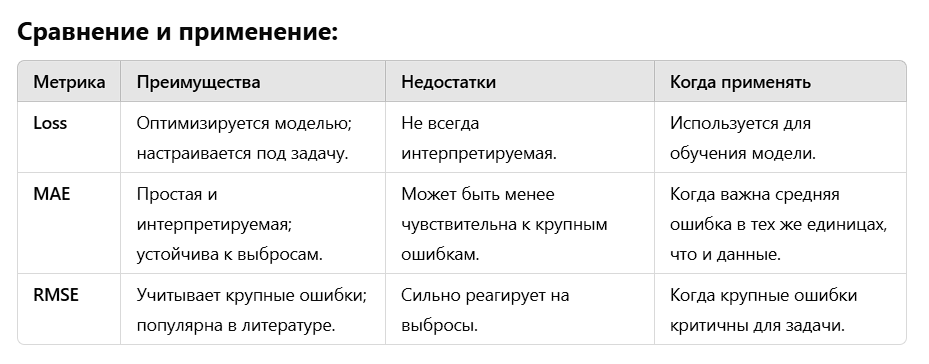

In [ ]:
# Занесем данные
data = {
    "Model": ["LSTM_price", "GRU_price", "LSTM_mult", "GRU_mult"],
    "Loss": [p_loss_lstm, p_loss_gru, m_loss_lstm, m_loss_gru],
    "MAE": [p_mae_lstm, p_mae_gru, m_mae_lstm, m_mae_gru],
    "RMSE": [p_rmse_lstm, p_rmse_gru, m_rmse_lstm, m_rmse_gru]
}

In [ ]:
# Создаем DataFrame
df = pd.DataFrame(data)
df

,Model,Loss,MAE,RMSE
0,LSTM_price,0.012,0.060,0.110
1,GRU_price,0.014,0.067,0.117
2,LSTM_mult,0.075,0.190,0.273
3,GRU_mult,0.094,0.219,0.306


Выводы: главный вывод который можно сделать из обученных моделей, что количество параметров не дало улучшения показателей, но увеличило скорость обучения, хотя модели основанные только на цене акций показали более точное предсказание и средняя квадратичная ошибка(RMSE) в них значительно ниже(более чем в 2 раза). Так же, можно сделать вывод, что модель GRU не смотря на меньшее количество параметров, показывает результаты сопоставимые с LSTM, но работает немного быстрее.

In [ ]:
# Теперь используем лучшую модель для предсказания реальных цен акций

In [ ]:
data = pd.read_csv('/content/prices.csv')

In [ ]:
data.head()

,id,company_id,date,close,open,high,low,volume,adj_close
0,0,24,2007-06-29,657.0,657.0,657.00,657.0,66,657.0
1,0,24,2007-07-02,669.0,669.0,669.00,669.0,1,669.0
2,0,24,2007-07-03,662.0,662.0,662.00,662.0,3,662.0
3,0,24,2007-07-04,639.0,645.0,645.00,639.0,27,639.0
4,0,24,2007-07-05,657.0,666.0,745.17,652.0,10538,657.0


In [ ]:
#Получение уникальных компаний
unique_companies = data['company_id'].unique()
unique_companies

array([  24,   42,   87,  190, 4982])

In [ ]:
# Загрузка модели
model = load_model('/content/DL_project_lstm.keras')

Делаем предсказание цены акций для каждой компании на следующие 30 дней

In [ ]:
results = []  # Итоговый список предсказаний

for company_id in unique_companies:
    # Фильтрация данных для компании
    company_data = data[data['company_id'] == company_id]

    # Убедимся, что данные компании непустые
    if company_data.empty:
        print(f"Пропускаем компанию {company_id}, данные отсутствуют")
        continue

    # Предобработка данных
    company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
    company_data.sort_values('date', inplace=True)              # Сортировка по дате
    prices = company_data['close'].values.reshape(-1, 1)

    # Определение последней известной даты
    last_known_date = company_data['date'].max()

    # Масштабирование цен
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    # Подготовка последних 30 точек для первого предсказания
    if len(scaled_prices) < 30:
        print(f"Пропускаем компанию {company_id}, данных меньше 30")
        continue

    input_data = scaled_prices[-30:].reshape(1, -1, 1)

    # Итеративное прогнозирование на 30 дней
    predictions = []
    current_date = last_known_date  # Установим дату на последнюю известную дату
    for i in range(30):
        # Предсказание модели
        predicted_scaled = model.predict(input_data)
        predicted = scaler.inverse_transform(predicted_scaled)  # Обратное масштабирование

        # Обновляем дату прогноза
        current_date += datetime.timedelta(days=1)

        # Сохраняем предсказание
        predictions.append({'company_id': company_id,
                            'date': current_date,
                            'predicted_price': predicted[0, 0]})

        # Обновление входных данных
        input_data = np.append(input_data[0][1:], predicted_scaled).reshape(1, -1, 1)

    # Сохранение результата для компании
    results.extend(predictions)

# Конвертация в DataFrame для анализа
results_df = pd.DataFrame(results)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


<ipython-input-77-c011395f01f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-77-c011395f01f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

<ipython-input-77-c011395f01f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-77-c011395f01f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

<ipython-input-77-c011395f01f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-77-c011395f01f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

<ipython-input-77-c011395f01f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-77-c011395f01f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

<ipython-input-77-c011395f01f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-77-c011395f01f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [ ]:
print(results_df)

     company_id       date  predicted_price
0            24 2024-10-12       452.831787
1            24 2024-10-13       452.788361
2            24 2024-10-14       452.689789
3            24 2024-10-15       452.523102
4            24 2024-10-16       452.294128
..          ...        ...              ...
145        4982 2024-11-06      1302.984863
146        4982 2024-11-07      1296.788696
147        4982 2024-11-08      1290.161865
148        4982 2024-11-09      1282.901855
149        4982 2024-11-10      1274.663452

[150 rows x 3 columns]


In [ ]:
results_df.loc[results_df['company_id'] == 4982]

,company_id,date,predicted_price
120,4982,2024-10-12,1719.092041
121,4982,2024-10-13,1702.135010
122,4982,2024-10-14,1677.267456
123,4982,2024-10-15,1646.190186
124,4982,2024-10-16,1610.941162
125,4982,2024-10-17,1574.040527
126,4982,2024-10-18,1536.946777
127,4982,2024-10-19,1501.096191
128,4982,2024-10-20,1468.103027
129,4982,2024-10-21,1438.738647


In [ ]:
# Загружаем реальные цены на прогнозируемый период
real_price = pd.read_csv('/content/real_price.csv')

In [ ]:
real_price.head()

,id,company_id,date,close,open,high,low,volume,adj_close
0,0,24,2024-10-11,644.0,639.5,645.9,634.4,386300,644.0
1,0,24,2024-10-14,647.5,641.8,654.0,636.8,491423,647.5
2,0,24,2024-10-15,652.9,651.7,660.0,649.0,410202,652.9
3,0,24,2024-10-16,643.0,658.0,665.0,640.0,519300,643.0
4,0,24,2024-10-17,637.4,642.4,644.0,635.1,381050,637.4


In [ ]:
real_price = real_price[['company_id', 'date', 'close']]

In [ ]:
real_price.head()

,company_id,date,close
0,24,2024-10-11 00:00:00,644.0
1,24,2024-10-14 00:00:00,647.5
2,24,2024-10-15 00:00:00,652.9
3,24,2024-10-16 00:00:00,643.0
4,24,2024-10-17 00:00:00,637.4


In [ ]:
# Преобразуем столбец 'date' в datetime в обоих DataFrame
real_price['date'] = pd.to_datetime(real_price['date'])
results_df['date'] = pd.to_datetime(results_df['date'])

# Теперь можно выполнять слияние
price_comparison = pd.merge(results_df, real_price, on=['company_id', 'date'], how='inner')


In [ ]:
price_comparison.loc[price_comparison['company_id'] == 24]

,company_id,date,predicted_price,close
0,24,2024-10-14,452.689789,647.5
1,24,2024-10-15,452.523102,652.9
2,24,2024-10-16,452.294128,643.0
3,24,2024-10-17,451.996765,637.4
4,24,2024-10-18,451.624054,636.3
5,24,2024-10-21,450.739349,634.7
6,24,2024-10-22,450.695770,620.9
7,24,2024-10-23,450.751556,610.6
8,24,2024-10-24,450.860626,604.0
9,24,2024-10-25,450.988037,581.2


In [ ]:
price_comparison.loc[price_comparison['company_id'] == 42]

,company_id,date,predicted_price,close
20,42,2024-10-14,686.472351,705.0
21,42,2024-10-15,686.486511,708.2
22,42,2024-10-16,686.472839,701.0
23,42,2024-10-17,686.468750,699.6
24,42,2024-10-18,686.477051,705.6
25,42,2024-10-21,686.854431,709.2
26,42,2024-10-22,686.972961,709.2
27,42,2024-10-23,687.057922,712.0
28,42,2024-10-24,687.128967,713.0
29,42,2024-10-25,687.198364,700.0


In [ ]:
price_comparison.loc[price_comparison['company_id'] == 87]

,company_id,date,predicted_price,close
40,87,2024-10-14,139.884705,172.45
41,87,2024-10-15,139.852051,174.90
42,87,2024-10-16,139.806763,188.95
43,87,2024-10-17,139.747864,189.60
44,87,2024-10-18,139.678879,174.10
45,87,2024-10-21,139.542160,179.20
46,87,2024-10-22,139.542038,178.95
47,87,2024-10-23,139.557159,171.15
48,87,2024-10-24,139.581009,164.10
49,87,2024-10-25,139.607773,157.15


In [ ]:
price_comparison.loc[price_comparison['company_id'] == 190]

,company_id,date,predicted_price,close
60,190,2024-10-14,70.382240,66.06
61,190,2024-10-15,70.598854,67.00
62,190,2024-10-16,70.748222,65.76
63,190,2024-10-17,70.837929,64.78
64,190,2024-10-18,70.865921,64.46
65,190,2024-10-21,71.115105,65.66
66,190,2024-10-22,71.200569,65.88
67,190,2024-10-23,71.281929,65.48
68,190,2024-10-24,71.387871,64.60
69,190,2024-10-25,71.508713,62.60


In [ ]:
price_comparison.loc[price_comparison['company_id'] == 4982]

,company_id,date,predicted_price,close
80,4982,2024-10-14,1677.267456,1840.0
81,4982,2024-10-15,1646.190186,1889.0
82,4982,2024-10-16,1610.941162,1880.0
83,4982,2024-10-17,1574.040527,1842.5
84,4982,2024-10-18,1536.946777,1853.5
85,4982,2024-10-21,1438.738647,1815.0
86,4982,2024-10-22,1413.904907,1812.0
87,4982,2024-10-23,1394.156738,1787.0
88,4982,2024-10-24,1378.959839,1650.5
89,4982,2024-10-25,1367.369019,1585.0


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

Посчитаем метрики для нашей модели

In [ ]:
y_true = price_comparison['close']  # Реальные цены
y_pred = price_comparison['predicted_price']  # Предсказанные цены

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# R2
r2 = r2_score(y_true, y_pred)

# Выводим результаты
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R^2: {r2}')

RMSE: 117.42023989809115
MAE: 72.97496535949708
MAPE: 13.118883527915436%
R^2: 0.954621748185928


В результате получаем, что средняя квадратичная ошибка(RMSE) равна 117.42, что показывает насколько сильно наша модель отклоняется от реальных значений, что довольно много и покупать или продавать акции с таким показателем не стоит.

Средняя абсолютная ошибка (MAE) показывает абсолютную разницу между предсказанными и реальными значениями, абсолютная разница довольно велика, т.к. чем меньше данный показатель, тем лучше модель.

Средняя абсолютная процентная ошибка (MAPE) показывает ошибку в процентах, из чего видно, что модель есть куда развивать, но в целом результат удовлетворительный.

R квадрат показывает, насколько хорошо предсказания объясняют вариацию реальных данных. Чем ближе R^2 к 1, тем лучше. Данный показатель для нашей не сложной модели не плохой.

**ИТОГОВОЙ ВЫВОД:**

В работе проведено исследование двух моделей (LSTM и GRU) для предсказания временных рядов(стоимости акций строительных компаний РФ торгующихся на Московской бирже), данные модели были обучены на двух вариантах датасетов, один из которых представлял классический временной ряд, второй дополнен множеством дополнительных параметров показывающие финансовые показатели компаний. Как оказалось, дополнительные параметры увеличили скорость обучения, но при этом снизилось качество моделей.

В результате предсказания и сравнения результата с реальными данными, модель показала не самые лучшие результаты из возможных, но и сама модель довольно простая, имеет чуть более 152 тысяч параметров, что совсем не много, поэтому можно считать, что модель справилась с задачей удовлетворительно. При наличии больших вычислительных ресурсов, модель можно доработать до нескольких миллионов параметров и обучить на большем количестве данных(возможно взять данные строительных компаний других стран и/или компаний других секторов с рынка РФ), что вероятнее всего приведет к наилучшим результатам, с точностью предсказания 99% и более, после чего данную модель можно было бы запускать в коммерческую эксплуатацию.